In [1]:
import numpy as np
import pandas as pd

In [2]:
file = 'C:\\Users\\reill\\Downloads\\Traffic_Crashes_-_Crashes.csv'
df = pd.DataFrame(pd.read_csv(file))

In [3]:
#Drop high NaN count columns
dropcols = []
for col in df:
    if (df[col].isna().sum() / len(df[col])) > 0.6:
        dropcols.append(col)
df.drop(dropcols, axis='columns', inplace=True)

#Drop unnecessary columns
df.drop(['CRASH_RECORD_ID', 'REPORT_TYPE', 'DATE_POLICE_NOTIFIED', 'LOCATION', 'CRASH_DATE', 'MOST_SEVERE_INJURY'], axis='columns', inplace=True)
df.replace('UNKNOWN', np.nan, inplace=True)

df = df.dropna(axis='index').reset_index(drop=True)

In [4]:
categorical = ['TRAFFIC_CONTROL_DEVICE',
       'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
       'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ALIGNMENT',
       'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'CRASH_TYPE', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE',
       'SEC_CONTRIBUTORY_CAUSE', 'MOST_SEVERE_INJURY']
#Removed street name and direction

In [5]:
numerical = ['POSTED_SPEED_LIMIT', 'STREET_NO', 'BEAT_OF_OCCURRENCE', 'NUM_UNITS', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE']

#This leaves out the datetime column

In [6]:
nonfatal = df[df['INJURIES_FATAL'] == 0.0]
hasfatal = df[df['INJURIES_FATAL'] != 0.0]

In [7]:
from sklearn.utils import resample

nonfatal_down = resample(nonfatal, replace=False, n_samples=1000)

In [8]:
down_df = pd.concat([nonfatal_down, hasfatal])

In [9]:
down_df = pd.concat([down_df[down_df['INJURIES_FATAL']>2], down_df]).drop_duplicates(keep=False)

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_df = down_df
scaled_df[numerical] = scaler.fit_transform(scaled_df[numerical])
scaled_df.head()

,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,...,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
141270,0.158973,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,ANGLE,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,2.0,0.0,0.035179,0.464410,0.673329,-0.015801,-0.049425
117671,0.158973,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,2.0,0.0,1.405843,0.955833,0.673329,0.123207,-0.008027
321415,0.158973,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,2.0,0.0,0.492067,-0.027014,0.673329,0.011709,-0.029010
482446,-2.568551,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,FIXED OBJECT,PARKING LOT,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,1.0,0.0,-0.421708,1.447256,0.371917,0.142111,-0.016277
606971,-2.568551,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,PARKING LOT,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,1.0,0.0,-0.878596,-0.518437,0.673329,0.158849,-0.063631


In [11]:
scaled_df = pd.get_dummies(scaled_df)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [13]:
x = scaled_df.drop(['INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN'], axis='columns')
y = scaled_df['INJURIES_FATAL']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [14]:
from sklearn.metrics import confusion_matrix, f1_score

forest_fatal = RandomForestClassifier(n_jobs=16)
forest_fatal.fit(x_train, y_train)

y_pred = forest_fatal.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))

[[165  38   0]
 [ 10 124   0]
 [  2   3   0]]
0.8404482058281889


In [15]:
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()
cross = GridSearchCV(rf, {'n_estimators':[50, 100, 200, 400, 600],
                          'max_depth':[1, 2, 4, None]}, scoring='f1_weighted', n_jobs=16)
cross.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=16,
             param_grid={'max_depth': [1, 2, 4, None],
                         'n_estimators': [50, 100, 200, 400, 600]},
             scoring='f1_weighted')

In [16]:
print(cross.best_estimator_)
print(cross.best_score_)

RandomForestClassifier(n_estimators=400)
0.8160142078330072


In [17]:
forest_final = RandomForestClassifier(n_estimators=600, n_jobs=16)
forest_final.fit(x_train, y_train)

y_pred = forest_final.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))

[[167  36   0]
 [  8 126   0]
 [  2   3   0]]
0.8519379258449475


In [18]:
big_test = df
big_test[numerical] = scaler.fit_transform(big_test[numerical])
big_test = pd.get_dummies(big_test)

x = big_test.drop(['INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN'], axis='columns')
y = big_test['INJURIES_FATAL']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

forest_big = RandomForestClassifier(n_estimators=50, n_jobs=16)
forest_big.fit(x_train, y_train)

y_pred = forest_big.predict(big_test.drop(['INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN'], axis='columns'))
print(confusion_matrix(big_test['INJURIES_FATAL'], y_pred))
print(f1_score(big_test['INJURIES_FATAL'], y_pred, average='weighted'))

[[613792      0      0      0      0]
 [   154    513      0      0      0]
 [    10      0     33      0      0]
 [     2      0      0      5      0]
 [     1      0      0      0      0]]
0.9997097486514672


In [19]:
forest_importances = pd.Series(forest_big.feature_importances_, index=x_test.columns).sort_values(ascending=False)[1:25]

In [20]:
forest_importances

LONGITUDE                                               0.071138
STREET_NO                                               0.069565
BEAT_OF_OCCURRENCE                                      0.054354
CRASH_HOUR                                              0.054100
CRASH_MONTH                                             0.046502
CRASH_DAY_OF_WEEK                                       0.041439
NUM_UNITS                                               0.027524
POSTED_SPEED_LIMIT                                      0.020421
FIRST_CRASH_TYPE_PEDESTRIAN                             0.013009
PRIM_CONTRIBUTORY_CAUSE_UNABLE TO DETERMINE             0.012744
SEC_CONTRIBUTORY_CAUSE_UNABLE TO DETERMINE              0.012737
SEC_CONTRIBUTORY_CAUSE_NOT APPLICABLE                   0.012545
TRAFFICWAY_TYPE_NOT DIVIDED                             0.010758
TRAFFICWAY_TYPE_DIVIDED - W/MEDIAN (NOT RAISED)         0.010341
LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD               0.009314
LIGHTING_CONDITION_DAYLIG

<Axes: >

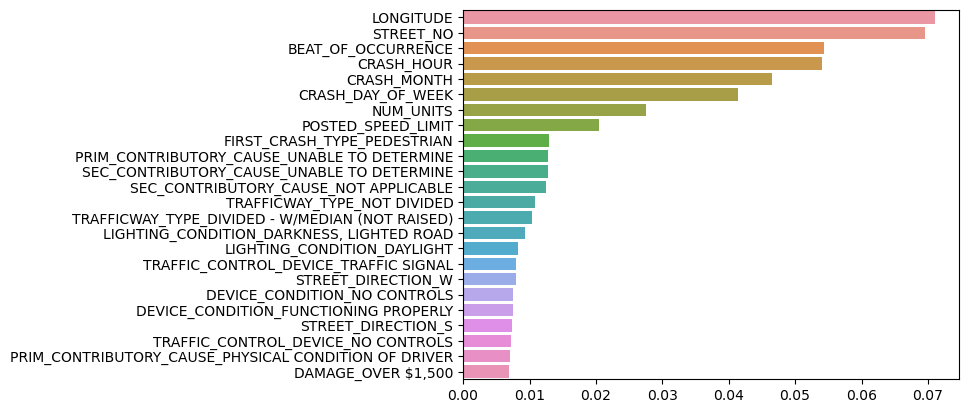

In [21]:
import seaborn as sns

sns.barplot(x=forest_importances, y=forest_importances.index)